In [1]:
from __future__ import division 

import gym
import numpy as np
import random
import tensorflow as tf 
import tensorflow.contrib.slim as slim
import matplotlib.pyplot as plt
import scipy.misc
import os
import sys
%matplotlib inline

In [2]:
from gridworld_v03_1 import gameEnv
env = gameEnv(partial=False, size=10)

In [3]:
class Qnetwork():
    def __init__(self, h_size, name = "main"):
        self.h_size = h_size
        self.net_name = name
        
        self.build_network()
        
    def build_network (self): #// h_size is the number of activation of conv4 
        #The network recieves a frame from the game, flattened into an array.
      
    #    self.scalarInput = tf.placeholder(shape=[None,84*84*3], dtype=tf.float32)
    #    self.imageIn = tf.reshape(self.scalarInput, shape=[-1,84,84,3])
        
        with tf.variable_scope(self.net_name):
            # Input(return value of env.reset) dimension
            # self.dimX = env.?

            self.dimX = len(env.objects) * 2
            self.dimY = env.actions

            # Dimensions of each layer 
            self.nInputLayer = self.dimX
            self.nHidden1 = h_size
            self.nHidden2 = h_size
            self.nHidden3 = h_size
            self.nOutputLayer = self.dimY

            self.input = tf.placeholder(shape=[None, self.dimX], dtype=tf.float32)
            self.output = tf.placeholder(shape=[None, self.dimY], dtype=tf.float32)

            # Weights of each layer
            self.W = {
                'W1': self.init_weight("W1", [self.nInputLayer, self.nHidden1]),
                'W2': self.init_weight("W2", [self.nHidden1, self.nHidden2]),
                'W3': self.init_weight("W3", [self.nHidden2, self.nHidden3]),
                'W4': self.init_weight("W4", [self.nHidden3, self.nOutputLayer])
            }

            # Bias of each layer
            self.b = {
                'b1': self.init_bias(self.nHidden1),
                'b2': self.init_bias(self.nHidden2),
                'b3': self.init_bias(self.nHidden3),
                'b4': self.init_bias(self.nOutputLayer)
            }

            # If we need,
            self.dropProb = 0.0


            self.hidden1 = tf.nn.relu(tf.add(tf.matmul(self.input, self.W['W1']), self.b['b1']))
            # self.hidden1 = tf.nn.dropout(self.hidden1, self.dropProb)

            self.hidden2 = tf.nn.relu(tf.add(tf.matmul(self.hidden1, self.W['W2']), self.b['b2']))
            # self.hidden2 = tf.nn.dropout(self.hidden2, self.dropProb)

            self.hidden3 = tf.nn.relu(tf.add(tf.matmul(self.hidden2, self.W['W3']), self.b['b3']))
            # self.hidden3 = tf.nn.dropout(self.hidden3, self.dropProb)

            self.output = tf.add(tf.matmul(self.hidden3, self.W['W4']), self.b['b4'])

            """
            self.conv1 = slim.conv2d(inputs=self.imageIn,
                                     num_outputs=32,
                                     kernel_size=[8,8],
                                     stride=[4,4],
                                     padding='VALID', 
                                     biases_initializer = None)

            self.conv2 = slim.conv2d(inputs=self.conv1,
                                     num_outputs=64,
                                     kernel_size=[4,4],
                                     stride=[2,2],
                                     padding='VALID',
                                     biases_initializer = None)

            self.conv3 = slim.conv2d(inputs=self.conv2,
                                     num_outputs=64,
                                     kernel_size=[3,3],
                                     stride=[1,1],
                                     padding='VALID',
                                     biases_initializer = None)

            self.conv4 = slim.conv2d(inputs=self.conv3,
                                     num_outputs=h_size,
                                     kernel_size=[7,7],
                                     stride=[1,1],
                                     padding='VALID',
                                     biases_initializer = None)
             """

            #We take the output from the final convolutional layer and split it into separated terms: advantage & value
            # I think the input dimension of our env is 1-dim 
            self.streamAC, self.streamVC = tf.split(self.output, 2, 1)
            self.streamA = slim.flatten(self.streamAC)
            self.streamV = slim.flatten(self.streamVC)

            xavier_init = tf.contrib.layers.xavier_initializer()

            self.AW = tf.Variable(xavier_init([self.dimY//2, env.actions]))
            self.VM = tf.Variable(xavier_init([self.dimY//2, 1]))

            self.Advantage = tf.matmul(self.streamA, self.AW)
            self.Value = tf.matmul(self.streamV, self.VM)

            #Then combine to obtain the final Q-value //why substract mean from Advantage?
            self.Qout = self.Value + tf.subtract(self.Advantage, tf.reduce_mean(self.Advantage,axis=1, keep_dims=True))
            self.predict = tf.argmax(self.Qout, 1)

            #Obtain the loss by taking the sum of squares difference between the target and predicted Q values
            self.targetQ = tf.placeholder(shape=[None], dtype=tf.float32)
            self.actions = tf.placeholder(shape=[None], dtype=tf.int32)
            self.actions_onehot = tf.one_hot(self.actions, env.actions, dtype=tf.float32) #// env.actions is probably number of actions

            self.Q = tf.reduce_sum(tf.multiply(self.Qout, self.actions_onehot), axis=1)

            self.td_error = tf.square(self.targetQ - self.Q)
            self.loss = tf.reduce_mean(self.td_error)

            self.trainer = tf.train.AdamOptimizer(learning_rate=0.0001)
            self.updateModel = self.trainer.minimize(self.loss)    
            
    def init_weight(self, name, shape):
        return tf.get_variable(name=name, shape=shape, initializer=tf.contrib.layers.xavier_initializer())

    def init_bias(self, n):
        return tf.Variable(tf.random_normal([n]))

In [4]:
class experience_buffer():
    def __init__(self, buffer_size = 50000):
        self.buffer = []
        self.buffer_size = buffer_size
        
    def add(self, experience):
        if len(self.buffer) + len(experience) >= self.buffer_size:
            self.buffer[0:(len(experience) + len(self.buffer)) - self.buffer_size] = []
        self.buffer.extend(experience)#// remove the necesary entries to make place for new experience
        
    def sample(self, size):
        return np.reshape(np.array(random.sample(self.buffer, size)),[size,5]) # buffer is experience tuple (size 4) plus "done" signal

In [5]:
def processState(states):
    return np.reshape(states,[84*84*3])

In [6]:
def updateTargetGraph(tfVars, tau):
    total_vars = len(tfVars)
    op_holder = []
    
    for idx,var in enumerate(tfVars[0:total_vars//2]): #// select the first half of the variables (the one that belong to the action choosing net) 
        op_holder.append(
            tfVars[idx+total_vars//2].assign(
                (var.value()*tau)+((1-tau)*tfVars[idx+total_vars//2].value())))#// basically take values from the primary net and modify then slithly with values from the second net, then return then for later use of model update 
    
    return op_holder

def updateTarget(op_holder, sess):
    for op in op_holder:
        sess.run(op)  

In [7]:
def get_copy_var_ops(*, dest_scope_name="target", src_scope_name="main"):
    op_holder = []
    
    src_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=src_scope_name)
    dest_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=dest_scope_name)
    
    for src_var, dest_var in zip(src_vars, dest_vars):
        op_holder.append(dest_var.assign(src_var.value()))
        
    return op_holder

In [8]:
#Set all the training parameters
batch_size = 32 #Number of experiences to use for each training step
update_freq = 5 #Frequency of a train step

y = .99 #Discount factor on the target Q-values

startE = 1 #Starting chance of random action
endE = 0.1 #Final chance of random action
#anneling_steps = 10000. #Number of training steps to decrease the explorarion parameter e 
anneling_steps = 50000

#num_episodes = 3*10000 #Number of episodes of the game environmet on which to train the network
num_episodes = 50000
#pre_train_steps = 10000 #Number of random action steps before training begins
pre_train_steps = 50000

#max_epLength = 100 #Maximun allowed length of a game episode
max_epLength = 100

load_model = False #Wheter to load a saved model
path = "./log" #Directory for checkpoints
#log_path = "./dqn_logs/logs" #Directory for logs

h_size = 512 #Number of activations of final conv layer

tau = 0.001 #Rate of update of target network values onto the primary network

#f = open(log_path,'w')

In [9]:
tf.reset_default_graph()

#Network instances
mainQN = Qnetwork(h_size, name="main")
targetQN = Qnetwork(h_size, name="target")

init = tf.global_variables_initializer()
saver = tf.train.Saver()

trainables = tf.trainable_variables()
targetOps = updateTargetGraph(trainables, tau)

myBuffer = experience_buffer()

#Set the rate of random action decrease
e = startE
stepDrop = (startE - endE)/anneling_steps

#Create lists to contain total reward and steps per episode
jList = []
rList = []
total_steps = 0

#Create path for checkpoints
if not os.path.exists(path):
    os.makedirs(path)

In [10]:
with tf.Session() as sess:
    sess.run(init)
    if load_model == True:
        print('Loading Model...')
        ckpt = tf.train.get_checkpoint_state(path)
        saver.restore(sess,ckpt.model_checkpoint_path)
    updateTarget(targetOps,sess) #Set the target network to be equal to the primary network.
    for i in range(num_episodes):
        if i%100 == 0:
            print("\n=====" + "Episode " + str(i) + "start =====" )
        episodeBuffer = experience_buffer()
        #Reset environment and get first new observation
        s = env.reset()
        # s = processState(s)
        d = False
        rAll = 0
        j = 0
        #The Q-Network
        while j < max_epLength: #If the agent takes longer than 200 moves to reach either of the blocks, end the trial.
            j+=1
            #Choose an action by greedily (with e chance of random action) from the Q-network
            if np.random.rand(1) < e or total_steps < pre_train_steps:
                a = np.random.randint(0,4)
            else:
                a = sess.run(mainQN.predict,feed_dict={mainQN.input:[s]})[0]
            s1,r,d = env.step(a)
            #print(s1, r, d)
            #s1 = processState(s1)
            total_steps += 1
            episodeBuffer.add(np.reshape(np.array([s,a,r,s1,d]),[1,5])) #Save the experience to our episode buffer.
            
            if total_steps > pre_train_steps:
                if e > endE:
                    e -= stepDrop
                
                if total_steps % (update_freq) == 0:
                    trainBatch = myBuffer.sample(batch_size) #Get a random batch of experiences.
                    #Below we perform the Double-DQN update to the target Q-values
                    Q1 = sess.run(mainQN.predict,feed_dict={mainQN.input:np.vstack(trainBatch[:,3])})
                    Q2 = sess.run(targetQN.Qout,feed_dict={targetQN.input:np.vstack(trainBatch[:,3])})
                    end_multiplier = -(trainBatch[:,4] - 1)
                    doubleQ = Q2[range(batch_size),Q1]
                    targetQ = trainBatch[:,2] + (y*doubleQ * end_multiplier)
                    #Update the network with our target values.
                    _ = sess.run(mainQN.updateModel, \
                        feed_dict={mainQN.input:np.vstack(trainBatch[:,0]),mainQN.targetQ:targetQ, mainQN.actions:trainBatch[:,1]})
                    
                    updateTarget(targetOps,sess) #Set the target network to be equal to the primary network.
            rAll += r
            s = s1
            
            if d == True:

                break
        
        myBuffer.add(episodeBuffer.buffer)
        jList.append(j)
        rList.append(rAll)
        #Periodically save the model. 
        if i % 1000 == 0:
            saver.save(sess,path+'/model-'+str(i)+'.cptk')
            print("Saved Model")
        if len(rList) % 10 == 0:
            print(total_steps,np.mean(rList[-10:]), e)
    saver.save(sess,path+'/model-'+str(i)+'.cptk')
print("Percent of succesful episodes: " + str(sum(rList)/num_episodes) + "%")


=====Episode 0start =====
Saved Model
433 -1.26 1
921 -1.56 1
1452 -1.02 1
1778 -1.1 1
2278 -2.0 1
2751 -1.88 1
3247 -1.52 1
3581 -0.76 1
4163 -1.76 1
4447 -1.48 1

=====Episode 100start =====
4813 -1.18 1
5235 -1.58 1
5586 -1.38 1
5891 -1.92 1
6274 -1.56 1
6546 -1.62 1
6848 -1.56 1
7300 -1.16 1
7903 -2.32 1
8348 -1.58 1

=====Episode 200start =====
8697 -1.5 1
9146 -1.32 1
9624 -1.28 1
10076 -1.92 1
10352 -1.22 1
10617 -0.82 1
10960 -1.38 1
11267 -1.24 1
11751 -2.2 1
12085 -1.42 1

=====Episode 300start =====
12581 -1.72 1
12887 -1.48 1
13162 -0.62 1
13495 -1.12 1
14028 -1.52 1
14318 -1.68 1
14799 -0.88 1
15126 -1.24 1
15423 -1.46 1
15819 -1.2 1

=====Episode 400start =====
16144 -1.24 1
16556 -1.44 1
17110 -1.42 1
17615 -1.86 1
17981 -1.38 1
18528 -1.28 1
18975 -1.7 1
19358 -1.62 1
19836 -1.38 1
20203 -0.8 1

=====Episode 500start =====
20479 -1.24 1
20759 -1.56 1
21347 -2.16 1
21660 -1.42 1
21895 -0.9 1
22205 -1.44 1
22542 -1.24 1
23029 -1.44 1
23373 -1.86 1
23713 -1.6 1

=====Epis

Saved Model
177077 0.1 0.09998200000085389
177957 -0.02 0.09998200000085389
178678 -0.08 0.09998200000085389
179512 -0.36 0.09998200000085389
180369 -0.26 0.09998200000085389
181272 -0.32 0.09998200000085389
182101 0.04 0.09998200000085389
183084 -0.04 0.09998200000085389
184066 -0.32 0.09998200000085389
184778 0.06 0.09998200000085389

=====Episode 3100start =====
185777 -0.1 0.09998200000085389
186763 0.02 0.09998200000085389
187763 -0.56 0.09998200000085389
188748 0.04 0.09998200000085389
189630 0.14 0.09998200000085389
190630 -0.18 0.09998200000085389
191365 -0.34 0.09998200000085389
192186 -0.18 0.09998200000085389
193083 -0.28 0.09998200000085389
193957 0.18 0.09998200000085389

=====Episode 3200start =====
194833 0.02 0.09998200000085389
195671 0.02 0.09998200000085389
196622 -0.06 0.09998200000085389
197470 -0.14 0.09998200000085389
198243 -0.04 0.09998200000085389
198907 -0.28 0.09998200000085389
199795 -0.02 0.09998200000085389
200642 0.16 0.09998200000085389
201551 -0.62 0.0

333219 0.3 0.09998200000085389
333734 0.24 0.09998200000085389
334259 0.38 0.09998200000085389
334784 0.28 0.09998200000085389
335332 -0.02 0.09998200000085389
335808 0.36 0.09998200000085389
336403 0.42 0.09998200000085389

=====Episode 5400start =====
336890 0.16 0.09998200000085389
337510 0.44 0.09998200000085389
337962 0.38 0.09998200000085389
338427 0.52 0.09998200000085389
339059 0.34 0.09998200000085389
339563 0.42 0.09998200000085389
340092 0.32 0.09998200000085389
340693 0.42 0.09998200000085389
341360 0.24 0.09998200000085389
341912 0.48 0.09998200000085389

=====Episode 5500start =====
342466 0.34 0.09998200000085389
342988 0.24 0.09998200000085389
343566 0.42 0.09998200000085389
344134 0.5 0.09998200000085389
344518 0.42 0.09998200000085389
344987 0.6 0.09998200000085389
345519 0.26 0.09998200000085389
346104 0.36 0.09998200000085389
346628 0.18 0.09998200000085389
347102 0.22 0.09998200000085389

=====Episode 5600start =====
347653 0.34 0.09998200000085389
348112 0.52 0.09

442923 0.6 0.09998200000085389

=====Episode 7700start =====
443376 0.54 0.09998200000085389
443831 0.52 0.09998200000085389
444171 0.36 0.09998200000085389
444616 0.64 0.09998200000085389
445080 0.56 0.09998200000085389
445547 0.52 0.09998200000085389
445947 0.7 0.09998200000085389
446355 0.44 0.09998200000085389
446898 0.1 0.09998200000085389
447392 0.64 0.09998200000085389

=====Episode 7800start =====
447951 0.52 0.09998200000085389
448483 0.5 0.09998200000085389
448949 0.08 0.09998200000085389
449366 0.52 0.09998200000085389
449852 0.36 0.09998200000085389
450152 0.68 0.09998200000085389
450640 0.26 0.09998200000085389
451080 0.7 0.09998200000085389
451577 0.5 0.09998200000085389
452149 0.68 0.09998200000085389

=====Episode 7900start =====
452744 0.42 0.09998200000085389
453177 0.6 0.09998200000085389
453825 0.56 0.09998200000085389
454347 0.44 0.09998200000085389
454791 0.5 0.09998200000085389
455122 0.84 0.09998200000085389
455760 0.26 0.09998200000085389
456170 0.66 0.09998200

535754 0.6 0.09998200000085389
536032 0.78 0.09998200000085389
536134 1.0 0.09998200000085389
536358 0.88 0.09998200000085389
536545 0.8 0.09998200000085389
536908 0.88 0.09998200000085389
537110 0.86 0.09998200000085389

=====Episode 10100start =====
537383 0.76 0.09998200000085389
537547 0.88 0.09998200000085389
537862 0.76 0.09998200000085389
538137 0.76 0.09998200000085389
538447 0.86 0.09998200000085389
538675 0.88 0.09998200000085389
538904 0.68 0.09998200000085389
539106 0.82 0.09998200000085389
539431 0.76 0.09998200000085389
539710 0.66 0.09998200000085389

=====Episode 10200start =====
540044 0.76 0.09998200000085389
540557 0.56 0.09998200000085389
540876 0.82 0.09998200000085389
541238 0.54 0.09998200000085389
541544 0.8 0.09998200000085389
541673 0.98 0.09998200000085389
541924 0.84 0.09998200000085389
542030 1.0 0.09998200000085389
542338 0.52 0.09998200000085389
542562 1.0 0.09998200000085389

=====Episode 10300start =====
542842 0.78 0.09998200000085389
542936 1.0 0.0999

580119 0.82 0.09998200000085389
580315 0.78 0.09998200000085389
580526 0.8 0.09998200000085389
580723 0.98 0.09998200000085389
580934 0.72 0.09998200000085389
581030 1.0 0.09998200000085389
581248 0.68 0.09998200000085389
581392 0.96 0.09998200000085389
581594 1.0 0.09998200000085389
581789 0.94 0.09998200000085389

=====Episode 12500start =====
581957 0.96 0.09998200000085389
582077 0.96 0.09998200000085389
582278 0.86 0.09998200000085389
582430 1.0 0.09998200000085389
582513 0.98 0.09998200000085389
582718 0.76 0.09998200000085389
582958 1.0 0.09998200000085389
583091 0.98 0.09998200000085389
583188 0.98 0.09998200000085389
583486 0.86 0.09998200000085389

=====Episode 12600start =====
583686 0.96 0.09998200000085389
583921 0.86 0.09998200000085389
584083 0.9 0.09998200000085389
584150 0.8 0.09998200000085389
584292 1.0 0.09998200000085389
584440 1.0 0.09998200000085389
584542 1.0 0.09998200000085389
584715 0.98 0.09998200000085389
584815 0.78 0.09998200000085389
585072 0.8 0.0999820

628259 0.88 0.09998200000085389
628408 0.98 0.09998200000085389
628682 0.86 0.09998200000085389

=====Episode 14800start =====
629119 0.7 0.09998200000085389
629374 0.9 0.09998200000085389
629532 1.0 0.09998200000085389
629917 0.9 0.09998200000085389
630144 0.76 0.09998200000085389
630459 0.9 0.09998200000085389
630702 0.98 0.09998200000085389
630837 0.8 0.09998200000085389
631131 0.48 0.09998200000085389
631427 0.34 0.09998200000085389

=====Episode 14900start =====
631691 0.88 0.09998200000085389
631920 0.86 0.09998200000085389
632265 0.34 0.09998200000085389
632464 0.38 0.09998200000085389
632685 0.88 0.09998200000085389
632985 0.64 0.09998200000085389
633274 0.9 0.09998200000085389
633585 0.8 0.09998200000085389
633766 0.06 0.09998200000085389
633952 0.74 0.09998200000085389

=====Episode 15000start =====
Saved Model
634141 0.98 0.09998200000085389
634370 0.86 0.09998200000085389
634585 0.98 0.09998200000085389
634944 0.84 0.09998200000085389
635150 1.0 0.09998200000085389
635313 0

683728 0.68 0.09998200000085389
684337 -0.3 0.09998200000085389
684811 0.66 0.09998200000085389
685172 0.78 0.09998200000085389
685568 0.64 0.09998200000085389
686123 0.06 0.09998200000085389
686697 0.24 0.09998200000085389
687315 0.56 0.09998200000085389

=====Episode 17200start =====
687741 0.6 0.09998200000085389
688454 0.38 0.09998200000085389
689318 -1.4 0.09998200000085389
689572 1.0 0.09998200000085389
690028 0.58 0.09998200000085389
690656 0.34 0.09998200000085389
691086 0.72 0.09998200000085389
691418 0.76 0.09998200000085389
691707 0.78 0.09998200000085389
692368 0.54 0.09998200000085389

=====Episode 17300start =====
692720 0.78 0.09998200000085389
693275 0.56 0.09998200000085389
693650 0.8 0.09998200000085389
694155 0.48 0.09998200000085389
694747 -0.06 0.09998200000085389
694933 0.88 0.09998200000085389
695254 0.68 0.09998200000085389
695780 0.58 0.09998200000085389
696288 0.36 0.09998200000085389
696739 0.62 0.09998200000085389

=====Episode 17400start =====
697402 0.3 0.

772307 0.68 0.09998200000085389
772637 0.46 0.09998200000085389
772862 0.84 0.09998200000085389

=====Episode 19500start =====
773147 0.9 0.09998200000085389
773305 0.58 0.09998200000085389
773493 1.0 0.09998200000085389
773704 0.88 0.09998200000085389
773780 1.0 0.09998200000085389
774052 0.8 0.09998200000085389
774119 0.8 0.09998200000085389
774556 0.7 0.09998200000085389
774664 1.0 0.09998200000085389
774884 1.0 0.09998200000085389

=====Episode 19600start =====
775045 0.98 0.09998200000085389
775431 0.8 0.09998200000085389
775572 0.52 0.09998200000085389
775716 1.0 0.09998200000085389
775932 0.68 0.09998200000085389
776282 0.68 0.09998200000085389
776623 0.6 0.09998200000085389
776981 0.42 0.09998200000085389
777131 1.0 0.09998200000085389
777588 0.68 0.09998200000085389

=====Episode 19700start =====
777866 0.88 0.09998200000085389
778193 0.72 0.09998200000085389
778388 0.88 0.09998200000085389
778633 0.8 0.09998200000085389
778747 0.8 0.09998200000085389
778982 0.9 0.099982000000

847480 0.3 0.09998200000085389
847953 0.28 0.09998200000085389
848420 0.78 0.09998200000085389
848859 0.44 0.09998200000085389
849256 0.68 0.09998200000085389
849747 0.32 0.09998200000085389
850230 0.3 0.09998200000085389

=====Episode 21900start =====
850767 0.3 0.09998200000085389
851193 0.5 0.09998200000085389
851717 0.32 0.09998200000085389
852255 0.38 0.09998200000085389
852763 0.48 0.09998200000085389
853367 0.28 0.09998200000085389
853858 0.46 0.09998200000085389
854197 0.58 0.09998200000085389
854866 0.36 0.09998200000085389
855342 0.46 0.09998200000085389

=====Episode 22000start =====
Saved Model
855983 0.02 0.09998200000085389
856416 0.72 0.09998200000085389
856953 0.2 0.09998200000085389
857394 0.84 0.09998200000085389
858014 0.64 0.09998200000085389
858471 0.42 0.09998200000085389
859183 0.42 0.09998200000085389
859639 0.28 0.09998200000085389
860134 0.28 0.09998200000085389
860669 0.42 0.09998200000085389

=====Episode 22100start =====
861292 -0.02 0.09998200000085389
861

954661 0.36 0.09998200000085389
954985 0.48 0.09998200000085389
955383 0.14 0.09998200000085389

=====Episode 24200start =====
955636 0.8 0.09998200000085389
955969 0.28 0.09998200000085389
956455 0.36 0.09998200000085389
956761 0.7 0.09998200000085389
957085 0.66 0.09998200000085389
957430 0.46 0.09998200000085389
957908 0.86 0.09998200000085389
958371 0.76 0.09998200000085389
958619 0.3 0.09998200000085389
959110 0.9 0.09998200000085389

=====Episode 24300start =====
959794 -0.06 0.09998200000085389
960396 0.48 0.09998200000085389
960696 0.24 0.09998200000085389
961242 0.58 0.09998200000085389
961777 0.76 0.09998200000085389
962221 0.78 0.09998200000085389
962654 0.3 0.09998200000085389
963319 0.68 0.09998200000085389
963864 -0.02 0.09998200000085389
964286 0.54 0.09998200000085389

=====Episode 24400start =====
964559 0.98 0.09998200000085389
964977 0.5 0.09998200000085389
965528 0.5 0.09998200000085389
965975 0.8 0.09998200000085389
966331 0.54 0.09998200000085389
966722 0.7 0.0999

1035192 0.66 0.09998200000085389

=====Episode 26500start =====
1035442 0.78 0.09998200000085389
1035764 0.78 0.09998200000085389
1036111 0.66 0.09998200000085389
1036425 0.8 0.09998200000085389
1036649 0.68 0.09998200000085389
1036933 0.8 0.09998200000085389
1037183 0.88 0.09998200000085389
1037519 0.8 0.09998200000085389
1037798 0.74 0.09998200000085389
1038161 0.6 0.09998200000085389

=====Episode 26600start =====
1038505 0.74 0.09998200000085389
1038778 0.8 0.09998200000085389
1039083 0.8 0.09998200000085389
1039276 0.9 0.09998200000085389
1039564 0.6 0.09998200000085389
1039952 -0.36 0.09998200000085389
1040149 0.9 0.09998200000085389
1040515 0.8 0.09998200000085389
1040744 0.86 0.09998200000085389
1041087 0.64 0.09998200000085389

=====Episode 26700start =====
1041303 1.0 0.09998200000085389
1041689 0.8 0.09998200000085389
1041863 0.7 0.09998200000085389
1042050 0.9 0.09998200000085389
1042222 0.88 0.09998200000085389
1042418 0.88 0.09998200000085389
1042587 0.9 0.099982000000853

1102193 0.68 0.09998200000085389
1102572 0.52 0.09998200000085389

=====Episode 28800start =====
1103016 -0.7 0.09998200000085389
1103533 0.72 0.09998200000085389
1103874 0.86 0.09998200000085389
1104304 -1.28 0.09998200000085389
1104595 0.8 0.09998200000085389
1104955 0.44 0.09998200000085389
1105170 0.7 0.09998200000085389
1105529 0.84 0.09998200000085389
1105740 0.76 0.09998200000085389
1106118 0.6 0.09998200000085389

=====Episode 28900start =====
1106378 0.66 0.09998200000085389
1106758 0.66 0.09998200000085389
1107052 0.7 0.09998200000085389
1107199 0.98 0.09998200000085389
1107575 0.78 0.09998200000085389
1107804 0.9 0.09998200000085389
1108050 0.64 0.09998200000085389
1108288 0.7 0.09998200000085389
1108606 0.7 0.09998200000085389
1108785 0.7 0.09998200000085389

=====Episode 29000start =====
Saved Model
1109221 0.5 0.09998200000085389
1109729 0.14 0.09998200000085389
1110008 0.9 0.09998200000085389
1110469 0.46 0.09998200000085389
1110651 0.68 0.09998200000085389
1111046 0.58 

1164906 0.58 0.09998200000085389
1165156 0.7 0.09998200000085389
1165402 0.68 0.09998200000085389

=====Episode 31100start =====
1165610 0.9 0.09998200000085389
1165706 0.58 0.09998200000085389
1165786 1.0 0.09998200000085389
1165953 0.88 0.09998200000085389
1166220 0.68 0.09998200000085389
1166506 0.54 0.09998200000085389
1166676 0.9 0.09998200000085389
1166859 0.8 0.09998200000085389
1167089 0.9 0.09998200000085389
1167245 0.86 0.09998200000085389

=====Episode 31200start =====
1167343 0.8 0.09998200000085389
1167741 0.74 0.09998200000085389
1167865 0.78 0.09998200000085389
1168220 0.66 0.09998200000085389
1168416 0.84 0.09998200000085389
1168592 1.0 0.09998200000085389
1168714 0.8 0.09998200000085389
1168839 0.98 0.09998200000085389
1168934 0.98 0.09998200000085389
1169091 0.4 0.09998200000085389

=====Episode 31300start =====
1169406 0.8 0.09998200000085389
1169641 -0.6 0.09998200000085389
1169908 0.98 0.09998200000085389
1170022 0.78 0.09998200000085389
1170163 0.8 0.0999820000008

1216562 0.74 0.09998200000085389
1216886 1.0 0.09998200000085389
1217137 0.78 0.09998200000085389

=====Episode 33400start =====
1217309 0.88 0.09998200000085389
1217485 0.78 0.09998200000085389
1217615 0.8 0.09998200000085389
1217855 0.68 0.09998200000085389
1218126 0.9 0.09998200000085389
1218278 0.78 0.09998200000085389
1218464 1.0 0.09998200000085389
1218664 0.88 0.09998200000085389
1218955 0.64 0.09998200000085389
1219222 0.9 0.09998200000085389

=====Episode 33500start =====
1219630 0.68 0.09998200000085389
1219929 0.44 0.09998200000085389
1220383 0.6 0.09998200000085389
1220612 0.68 0.09998200000085389
1220863 -0.22 0.09998200000085389
1221092 0.9 0.09998200000085389
1221500 0.28 0.09998200000085389
1221702 0.86 0.09998200000085389
1221855 0.88 0.09998200000085389
1222016 0.62 0.09998200000085389

=====Episode 33600start =====
1222280 0.58 0.09998200000085389
1222409 0.98 0.09998200000085389
1222645 0.68 0.09998200000085389
1222859 0.7 0.09998200000085389
1223013 0.78 0.09998200

1269806 0.78 0.09998200000085389
1270027 0.98 0.09998200000085389
1270293 0.8 0.09998200000085389

=====Episode 35700start =====
1270536 0.86 0.09998200000085389
1270912 0.52 0.09998200000085389
1271112 1.0 0.09998200000085389
1271422 0.52 0.09998200000085389
1271624 0.7 0.09998200000085389
1271847 0.66 0.09998200000085389
1272107 0.86 0.09998200000085389
1272393 1.0 0.09998200000085389
1272714 0.32 0.09998200000085389
1273032 0.8 0.09998200000085389

=====Episode 35800start =====
1273211 0.88 0.09998200000085389
1273483 1.0 0.09998200000085389
1273682 0.84 0.09998200000085389
1273903 0.76 0.09998200000085389
1274041 1.0 0.09998200000085389
1274344 0.6 0.09998200000085389
1274496 0.96 0.09998200000085389
1274806 0.42 0.09998200000085389
1274911 0.98 0.09998200000085389
1275396 0.28 0.09998200000085389

=====Episode 35900start =====
1275757 0.84 0.09998200000085389
1276242 0.76 0.09998200000085389
1276390 1.0 0.09998200000085389
1276672 0.5 0.09998200000085389
1276841 0.98 0.09998200000

1328101 1.0 0.09998200000085389
1328194 0.98 0.09998200000085389

=====Episode 38000start =====
Saved Model
1328442 0.8 0.09998200000085389
1328671 -0.74 0.09998200000085389
1328835 1.0 0.09998200000085389
1328972 0.98 0.09998200000085389
1329167 0.9 0.09998200000085389
1329291 0.78 0.09998200000085389
1329409 1.0 0.09998200000085389
1329588 0.9 0.09998200000085389
1329713 0.98 0.09998200000085389
1329889 0.88 0.09998200000085389

=====Episode 38100start =====
1330114 0.88 0.09998200000085389
1330390 0.58 0.09998200000085389
1330810 0.76 0.09998200000085389
1330947 0.5 0.09998200000085389
1331375 0.84 0.09998200000085389
1331555 0.66 0.09998200000085389
1331851 0.78 0.09998200000085389
1332082 0.9 0.09998200000085389
1332428 0.58 0.09998200000085389
1332659 0.9 0.09998200000085389

=====Episode 38200start =====
1332826 0.9 0.09998200000085389
1332995 0.88 0.09998200000085389
1333155 0.88 0.09998200000085389
1333305 0.66 0.09998200000085389
1333535 0.86 0.09998200000085389
1333747 0.78 

1373522 0.68 0.09998200000085389
1373839 0.9 0.09998200000085389

=====Episode 40300start =====
1374128 0.64 0.09998200000085389
1374434 0.8 0.09998200000085389
1374753 0.72 0.09998200000085389
1374929 1.0 0.09998200000085389
1375193 0.66 0.09998200000085389
1375470 0.58 0.09998200000085389
1375885 0.72 0.09998200000085389
1376218 0.9 0.09998200000085389
1376486 0.96 0.09998200000085389
1376783 0.9 0.09998200000085389

=====Episode 40400start =====
1376909 1.0 0.09998200000085389
1377189 0.78 0.09998200000085389
1377385 0.78 0.09998200000085389
1377688 0.8 0.09998200000085389
1377927 0.9 0.09998200000085389
1378130 0.8 0.09998200000085389
1378566 0.58 0.09998200000085389
1378786 0.78 0.09998200000085389
1379067 0.8 0.09998200000085389
1379381 0.64 0.09998200000085389

=====Episode 40500start =====
1379767 0.78 0.09998200000085389
1380245 0.48 0.09998200000085389
1380534 0.86 0.09998200000085389
1380778 0.96 0.09998200000085389
1381020 0.7 0.09998200000085389
1381429 0.76 0.099982000000

1462214 0.88 0.09998200000085389
1462459 0.88 0.09998200000085389
1462617 0.88 0.09998200000085389
1462780 0.88 0.09998200000085389

=====Episode 42600start =====
1462935 0.9 0.09998200000085389
1463099 0.48 0.09998200000085389
1463313 0.88 0.09998200000085389
1463500 0.3 0.09998200000085389
1463704 0.7 0.09998200000085389
1463857 0.9 0.09998200000085389
1464022 0.9 0.09998200000085389
1464215 0.68 0.09998200000085389
1464543 0.7 0.09998200000085389
1464741 0.86 0.09998200000085389

=====Episode 42700start =====
1464911 0.64 0.09998200000085389
1465090 0.9 0.09998200000085389
1465245 0.88 0.09998200000085389
1465424 0.9 0.09998200000085389
1465710 0.46 0.09998200000085389
1466057 0.58 0.09998200000085389
1466465 0.16 0.09998200000085389
1466705 0.7 0.09998200000085389
1466902 0.88 0.09998200000085389
1467243 0.36 0.09998200000085389

=====Episode 42800start =====
1467595 0.48 0.09998200000085389
1467919 0.7 0.09998200000085389
1468146 0.48 0.09998200000085389
1468398 0.68 0.09998200000

1512449 0.7 0.09998200000085389
1512621 0.86 0.09998200000085389
1512825 0.88 0.09998200000085389
1513118 0.8 0.09998200000085389
1513407 0.48 0.09998200000085389

=====Episode 44900start =====
1513700 0.7 0.09998200000085389
1513855 0.88 0.09998200000085389
1514108 0.68 0.09998200000085389
1514479 0.46 0.09998200000085389
1514687 0.9 0.09998200000085389
1514979 0.76 0.09998200000085389
1515447 -0.04 0.09998200000085389
1515723 -0.1 0.09998200000085389
1515855 1.0 0.09998200000085389
1516315 -0.98 0.09998200000085389

=====Episode 45000start =====
Saved Model
1516498 0.88 0.09998200000085389
1516724 0.66 0.09998200000085389
1516954 0.84 0.09998200000085389
1517237 0.78 0.09998200000085389
1517433 1.0 0.09998200000085389
1517892 0.58 0.09998200000085389
1518028 0.96 0.09998200000085389
1518247 0.88 0.09998200000085389
1518524 0.98 0.09998200000085389
1518824 0.56 0.09998200000085389

=====Episode 45100start =====
1519018 0.68 0.09998200000085389
1519326 0.54 0.09998200000085389
1519531 

1566472 0.48 0.09998200000085389
1566708 0.64 0.09998200000085389
1567044 0.5 0.09998200000085389
1567315 0.8 0.09998200000085389
1567554 0.86 0.09998200000085389
1567713 0.68 0.09998200000085389
1568014 0.58 0.09998200000085389

=====Episode 47200start =====
1568171 0.64 0.09998200000085389
1568322 0.86 0.09998200000085389
1568535 0.8 0.09998200000085389
1568728 0.9 0.09998200000085389
1568846 1.0 0.09998200000085389
1568997 0.9 0.09998200000085389
1569089 1.0 0.09998200000085389
1569244 0.88 0.09998200000085389
1569501 0.78 0.09998200000085389
1569785 0.56 0.09998200000085389

=====Episode 47300start =====
1569948 0.88 0.09998200000085389
1570115 0.9 0.09998200000085389
1570288 0.86 0.09998200000085389
1570633 0.66 0.09998200000085389
1570878 0.8 0.09998200000085389
1571036 0.68 0.09998200000085389
1571631 0.14 0.09998200000085389
1571811 0.7 0.09998200000085389
1572085 0.86 0.09998200000085389
1572266 0.9 0.09998200000085389

=====Episode 47400start =====
1572576 0.68 0.099982000000

1619748 0.9 0.09998200000085389
1620196 -0.56 0.09998200000085389
1620507 0.9 0.09998200000085389
1620821 0.48 0.09998200000085389
1621061 0.88 0.09998200000085389
1621279 0.66 0.09998200000085389
1621626 0.58 0.09998200000085389
1621838 0.86 0.09998200000085389

=====Episode 49500start =====
1622019 0.9 0.09998200000085389
1622184 0.86 0.09998200000085389
1622470 0.82 0.09998200000085389
1622657 0.88 0.09998200000085389
1622933 0.7 0.09998200000085389
1623202 0.9 0.09998200000085389
1623380 0.66 0.09998200000085389
1623668 0.84 0.09998200000085389
1623877 0.9 0.09998200000085389
1624100 0.5 0.09998200000085389

=====Episode 49600start =====
1624333 0.88 0.09998200000085389
1624617 0.88 0.09998200000085389
1624846 0.86 0.09998200000085389
1625125 0.76 0.09998200000085389
1625318 0.9 0.09998200000085389
1625529 0.9 0.09998200000085389
1625692 0.98 0.09998200000085389
1625905 0.7 0.09998200000085389
1626057 0.7 0.09998200000085389
1626287 0.7 0.09998200000085389

=====Episode 49700start 

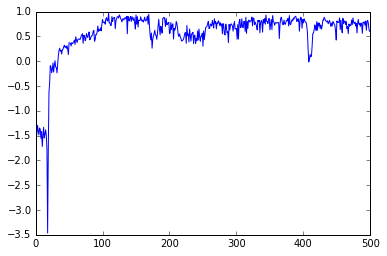

In [11]:
rMat = np.resize(np.array(rList), [len(rList)//100,100])
rMean = np.average(rMat, 1)
plt.plot(rMean)

------------------------------------

## Testing the network performance

This first piece of code aims to make a step by step walkthrough the game to see what actions is taken
For some reason the actor is performing a single action. Need to debug.

In [13]:
#Create lists to contain total reward and steps per episode
jList_t = []
rList_t = []
total_steps_t = 0

In [14]:
sess = tf.InteractiveSession()

In [15]:
ckpt = tf.train.get_checkpoint_state(path)
saver.restore(sess, ckpt.model_checkpoint_path)    

INFO:tensorflow:Restoring parameters from ./dqn_logs/model-29999.cptk


[2017-06-05 16:39:39,215] Restoring parameters from ./dqn_logs/model-29999.cptk


In [16]:
#Reset environment and get the first new observation
s = env.reset()
#s = processState(s)
d = False
rAll_t = 0
j_t = 0        

Action: 1
Reward: 0 , Done: False


TypeError: Invalid dimensions for image data

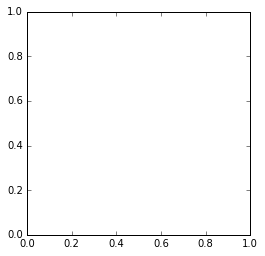

In [17]:
#Choose an action by greedily picking from the Q-net
a = sess.run(mainQN.predict, feed_dict={mainQN.input:[s]})[0]# //the extra [0] takes the value of the sing-entry array that Main1.predict returns

print ("Action: %d" % a)
s1, r, d = env.step(a)
print ("Reward: %d , Done: %s" % (r, d))
plt.imshow(s1, interpolation = "nearest")
#s1 = processState(s1)#// flatten the return frame
total_steps_t += 1
                        
rAll_t += r
s = s1


if d == True:
    print("End of training episode")
    jList_t.append(j_t)
    rList_t.append(rAll_t)
            
    if len(rList_t) % 10 == 0:
        accumR = np.mean(rList_t[-10:])
        log = str(total_steps_t) +"\t"+ str(accumR) 
        print(log)            

In [18]:
sess.close()

Test the actor in an automatic way. The issue is the same, the actor chooses the same action constantly

In [12]:
#Create lists to contain total reward and steps per episode
jList_t = []
rList_t = []
total_steps_t = 0

# Test setting parameters
load_model = True
num_test_episodes = 5000

#Create lists to contain total reward and steps per episode
with tf.Session() as sess:
    
    if load_model == True:
        print('Loading Model...')
        ckpt = tf.train.get_checkpoint_state(path)
        saver.restore(sess, ckpt.model_checkpoint_path)
    
    for i in range(num_test_episodes):
        
        #Reset environment and get the first new observation
        s = env.reset()
        #s = processState(s)
        d = False
        rAll_t = 0
        j_t = 0
        
        #Q-Network
        while j_t < max_epLength: #If the agent takes longer than 200 moves to reach either of the blocks, end the trail
            j_t+=1
            
            #Choose an action by greedily picking from the Q-net
            a = sess.run(mainQN.predict, feed_dict={mainQN.input:[s]})[0]# //the extra [0] takes the value of the sing-entry array that Main1.predict returns
                
            s1, r, d = env.step(a)
           #s1 = processState(s1)#// flatten the return frame
            total_steps_t += 1
                        
              
            rAll_t += r
            s = s1
                
            if d == True:
                break
                        
        jList_t.append(j_t)
        rList_t.append(rAll_t)
            
        if len(rList_t) % 10 == 0:
            accumR = np.mean(rList_t[-10:])
            log = str(total_steps_t) +"\t"+ str(accumR) 
            print(log)
            #f.write(log)
                
    
final_log = "Percent of sucessful episodes: " + str(sum(rList_t)/num_test_episodes) + "%"
print(final_log)

Loading Model...
INFO:tensorflow:Restoring parameters from ./log/model-49999.cptk


[2017-06-06 01:59:13,849] Restoring parameters from ./log/model-49999.cptk


246	0.8
587	0.7
833	0.8
1174	0.7
1420	0.8
1761	0.7
2007	0.8
2348	0.7
2594	0.8
2935	0.7
3181	0.8
3522	0.7
3768	0.8
4109	0.7
4355	0.8
4696	0.7
4942	0.8
5283	0.7
5529	0.8
5870	0.7
6116	0.8
6457	0.7
6703	0.8
7044	0.7
7290	0.8
7631	0.7
7877	0.8
8218	0.7
8464	0.8
8805	0.7
9051	0.8
9392	0.7
9638	0.8
9979	0.7
10225	0.8
10566	0.7
10812	0.8
11153	0.7
11399	0.8
11740	0.7
11986	0.8
12327	0.7
12573	0.8
12914	0.7
13160	0.8
13501	0.7
13747	0.8
14088	0.7
14334	0.8
14675	0.7
14921	0.8
15262	0.7
15508	0.8
15849	0.7
16095	0.8
16436	0.7
16682	0.8
17023	0.7
17269	0.8
17610	0.7
17856	0.8
18197	0.7
18443	0.8
18784	0.7
19030	0.8
19371	0.7
19617	0.8
19958	0.7
20204	0.8
20545	0.7
20791	0.8
21132	0.7
21378	0.8
21719	0.7
21965	0.8
22306	0.7
22552	0.8
22893	0.7
23139	0.8
23480	0.7
23726	0.8
24067	0.7
24313	0.8
24654	0.7
24900	0.8
25241	0.7
25487	0.8
25828	0.7
26074	0.8
26415	0.7
26661	0.8
27002	0.7
27248	0.8
27589	0.7
27835	0.8
28176	0.7
28422	0.8
28763	0.7
29009	0.8
29350	0.7
29596	0.8
29937	0.7
30183	0.8
30524	0

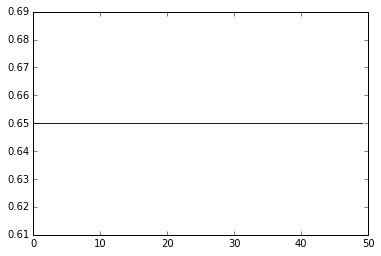

In [20]:
rMat_t = np.resize(np.array(rList_t), [len(rList_t)//100,100])
rMean_t = np.average(rMat_t, 1)
plt.plot(rMean_t)

---------------------------------------------

## Test Random Actor

In [35]:
# Test setting parameters for random actor
num_test_episodes = 5000

#Create lists to contain total reward and steps per episode
jList_t = []
rList_t = []
total_steps_t = 0

_,_ = env.checkGoal()

with tf.Session() as sess:
    sess.run(init)
        
    for i in range(num_test_episodes):
        
        d = False
        rAll_t = 0
        j_t = 0
        
        while j_t < max_epLength: #If the agent takes longer than 50 moves to reach either of the blocks, end the trail
            j_t += 1
            
            a = np.random.randint(0,4)
                
            s1, r, d = env.step(a)
            s1 = processState(s1)#// flatten the return frame
            total_steps_t += 1
                      
            rAll_t += r
            s = s1
                
            if d == True:
                break
                        
        
        jList_t.append(j_t)
        rList_t.append(rAll_t)
            
        if len(rList_t) % 10 == 0:
            accumR = np.mean(rList_t[-10:])
            log = str(total_steps_t) +"\t"+ str(accumR) 
            print(log)
                           
    
final_log = "Percent of sucessful test episodes: " + str(sum(rList_t)/num_test_episodes) + "%"
print(final_log)

62	-0.6
140	-1.0
248	-1.0
367	-0.8
427	-0.8
564	-0.6
607	-0.6
730	-0.9
806	-0.8
891	-0.6
1013	-1.0
1129	-0.8
1209	-0.4
1307	-0.6
1406	-0.9
1508	-0.6
1562	-1.0
1608	-1.0
1751	-0.8
1836	-0.8
1912	-0.6
2003	-0.6
2101	-0.8
2194	-1.0
2268	-1.0
2314	-0.8
2394	-0.6
2477	-1.0
2575	-1.0
2671	-1.0
2753	-0.8
2828	-0.8
2936	-0.8
3003	-1.0
3082	-0.6
3173	-0.6
3318	-0.6
3429	-0.8
3575	-0.5
3740	-0.4
3828	-0.2
3975	-0.8
4082	-1.0
4133	-0.8
4202	-0.8
4267	-0.6
4386	-0.8
4505	-0.4
4626	-0.4
4693	-1.0
4745	-0.8
4792	-0.8
4860	-0.6
4974	-0.9
5031	-0.6
5066	-0.8
5207	-0.8
5313	-0.6
5410	-0.8
5513	-1.0
5582	-0.8
5683	-0.6
5811	-1.0
5865	-0.8
5954	-0.8
6006	-0.2
6121	-1.0
6246	-0.8
6300	-0.8
6394	-0.6
6516	-0.7
6616	-0.8
6679	-0.4
6758	-0.6
6842	-0.4
6887	-0.4
6955	-0.8
7006	-0.6
7111	-0.8
7225	-0.4
7268	-1.0
7397	-0.8
7455	-0.6
7529	-1.0
7564	-0.6
7643	-0.8
7731	-0.8
7886	-1.0
7990	-0.6
8073	-0.8
8120	-0.6
8186	-1.0
8213	-0.8
8283	-0.4
8357	-0.8
8417	-0.8
8510	-1.0
8649	-1.0
8715	-0.4
8798	-0.8
8884	-0.6
8

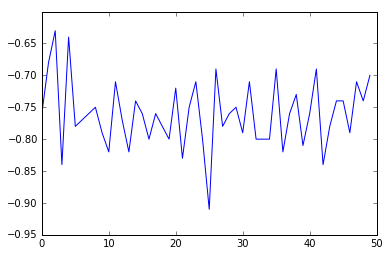

In [34]:
rMat_t = np.resize(np.array(rList_t), [len(rList_t)//100,100])
rMean_t = np.average(rMat_t, 1)
plt.plot(rMean_t)